In [1]:
import os
import random
from pathlib import Path

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
RANDOM_STATE = 42
SCORING_METRIC = "balanced_accuracy"

DATASET_DIR = Path("../data/augmented")
CLASS_NAMES = sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()])
if not DATASET_DIR.exists():
	print(f"Directory not found: {DATASET_DIR}. Creating it...")
	DATASET_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path("../models")
print(f"Kelas yang ditemukan: {CLASS_NAMES}")

Kelas yang ditemukan: ['belum-matang', 'matang', 'setengah-matang']


In [2]:
IMAGE_EXT = {".jpg", ".jpeg", ".png", ".bmp"}

def list_images(class_dir: Path):
    return [p for p in class_dir.glob("**/*") if p.suffix.lower() in IMAGE_EXT]

dataset_overview = []
for cls in CLASS_NAMES:
    files = list_images(DATASET_DIR / cls)
    dataset_overview.append({"label": cls, "jumlah_gambar": len(files)})

df_overview = pd.DataFrame(dataset_overview).sort_values("label")
display(df_overview)
print(f"Total gambar: {df_overview['jumlah_gambar'].sum()}")

sample_listing = {cls: list_images(DATASET_DIR / cls)[:3] for cls in CLASS_NAMES}
for cls, files in sample_listing.items():
    print(f"\nContoh file kelas {cls}:")
    for f in files:
        print(f"- {f.relative_to(DATASET_DIR)}")

,label,jumlah_gambar
0,belum-matang,378
1,matang,360
2,setengah-matang,414


Total gambar: 1152

Contoh file kelas belum-matang:
- belum-matang\image (100).jpg
- belum-matang\image (100)_aug1_noise.jpg
- belum-matang\image (100)_aug2_rotate_-15.jpg

Contoh file kelas matang:
- matang\Copy of image (70).jpg
- matang\Copy of image (70)_aug1_flip_v.jpg
- matang\Copy of image (70)_aug2_bright_0.8.jpg

Contoh file kelas setengah-matang:
- setengah-matang\image (1).jpg
- setengah-matang\image (1)_aug1_zoom_1.2.jpg
- setengah-matang\image (1)_aug2_shift_left.jpg


In [3]:
IMG_SIZE = (224, 224)
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))


def gray_world_white_balance(img_bgr: np.ndarray) -> np.ndarray:
    img = img_bgr.astype(np.float32)
    avg_bgr = img.mean(axis=(0, 1))
    gray_val = avg_bgr.mean()
    scale = gray_val / (avg_bgr + 1e-6)
    balanced = img * scale
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)
    return balanced


def keep_largest_component(binary_mask: np.ndarray) -> np.ndarray:
    labels = measure.label(binary_mask, connectivity=2)
    if labels.max() == 0:
        return binary_mask
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = counts.argmax()
    mask = (labels == largest).astype(np.uint8) * 255
    return mask


def build_fruit_mask(hsv_img: np.ndarray) -> np.ndarray:
    bg_green = cv2.inRange(hsv_img, (30, 40, 0), (90, 255, 200))
    bg_brown = cv2.inRange(hsv_img, (5, 30, 0), (25, 200, 150))
    background = cv2.bitwise_or(bg_green, bg_brown)

    fruit_candidate = cv2.inRange(hsv_img, (0, 40, 40), (179, 255, 255))
    mask = cv2.bitwise_and(fruit_candidate, cv2.bitwise_not(background))

    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = keep_largest_component(mask)
    return mask


def mask_aware_crop(img: np.ndarray, mask: np.ndarray, pad_ratio: float = 0.05):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        fallback_mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        return img.copy(), fallback_mask
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    h, w = img.shape[:2]
    pad_x = int((x_max - x_min) * pad_ratio)
    pad_y = int((y_max - y_min) * pad_ratio)
    x_min = max(x_min - pad_x, 0)
    x_max = min(x_max + pad_x, w)
    y_min = max(y_min - pad_y, 0)
    y_max = min(y_max + pad_y, h)
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask


def preprocess_image(path: Path) -> dict:
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        raise ValueError(f"Gagal membaca {path}")

    img_rgb_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    wb = gray_world_white_balance(img_bgr)
    denoised = cv2.bilateralFilter(wb, d=9, sigmaColor=75, sigmaSpace=75)

    hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
    mask = build_fruit_mask(hsv)

    cropped_bgr, cropped_mask = mask_aware_crop(denoised, mask)
    resized_bgr = cv2.resize(cropped_bgr, IMG_SIZE)
    resized_mask = cv2.resize(cropped_mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    hsv_resized = cv2.cvtColor(resized_bgr, cv2.COLOR_BGR2HSV)
    hsv_resized[:, :, 2] = CLAHE.apply(hsv_resized[:, :, 2])
    enhanced_bgr = cv2.cvtColor(hsv_resized, cv2.COLOR_HSV2BGR)

    gray = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2GRAY)
    gray_equalized = cv2.equalizeHist(gray)

    enhanced_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)
    normalized = enhanced_rgb.astype(np.float32) / 255.0

    return {
        "original": img_rgb_original,
        "white_balanced": cv2.cvtColor(wb, cv2.COLOR_BGR2RGB),
        "mask": resized_mask,
        "cropped": cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2RGB),
        "enhanced": enhanced_rgb,
        "hsv": hsv_resized,
        "gray_equalized": gray_equalized,
        "normalized": normalized,
    }


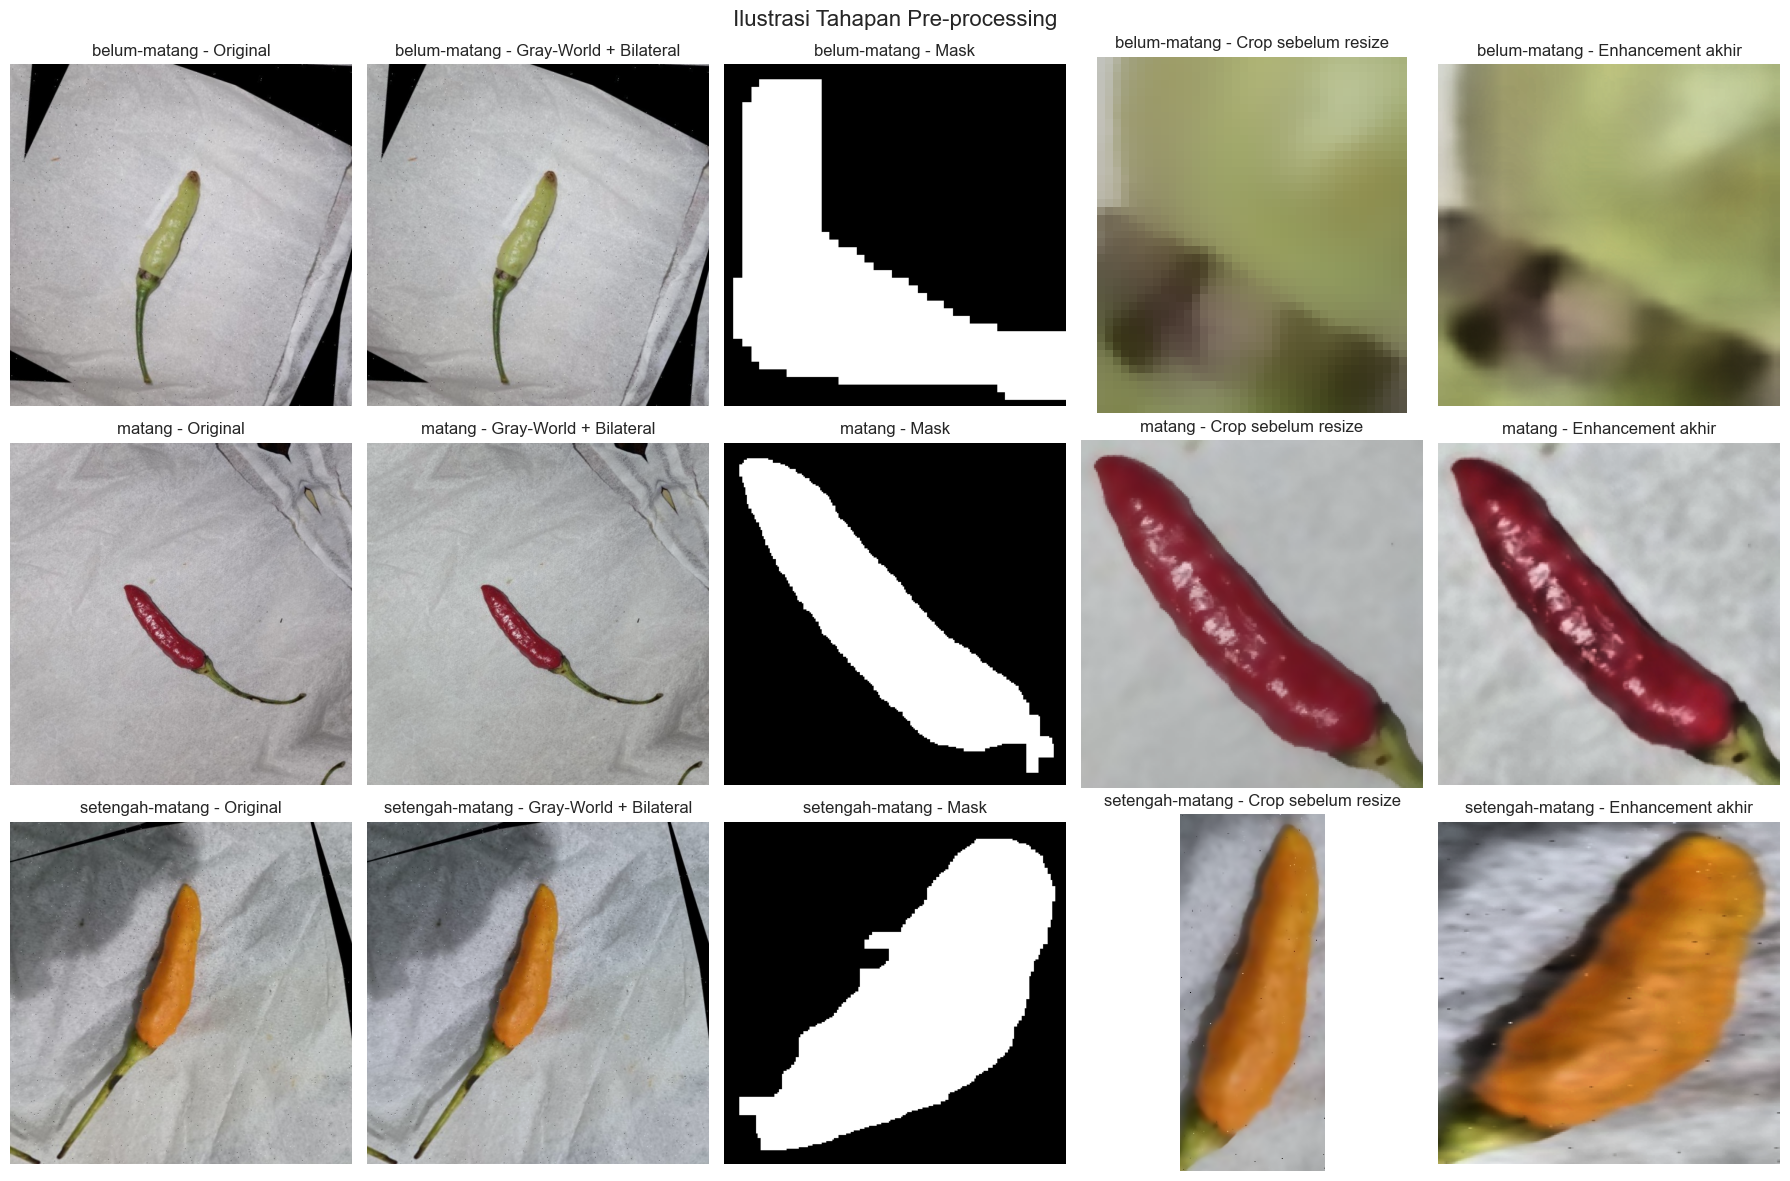

In [4]:
def plot_preprocessing_examples(samples_per_class: int = 1):
    cols = [
        "Original",
        "Gray-World + Bilateral",
        "Mask",
        "Crop sebelum resize",
        "Enhancement akhir",
    ]
    fig, axes = plt.subplots(len(CLASS_NAMES), len(cols), figsize=(18, 4 * len(CLASS_NAMES)))
    if len(CLASS_NAMES) == 1:
        axes = np.expand_dims(axes, 0)

    for row, cls in enumerate(CLASS_NAMES):
        files = list_images(DATASET_DIR / cls)
        if not files:
            continue
        sample_path = random.choice(files)
        processed = preprocess_image(sample_path)

        visual_data = [
            processed["original"],
            processed["white_balanced"],
            processed["mask"],
            processed["cropped"],
            processed["enhanced"],
        ]
        for col, ax in enumerate(axes[row]):
            if col == 2:
                ax.imshow(visual_data[col], cmap="gray")
            else:
                ax.imshow(visual_data[col])
            ax.set_title(f"{cls} - {cols[col]}")
            ax.axis("off")

    fig.suptitle("Ilustrasi Tahapan Pre-processing", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_preprocessing_examples()

In [5]:
def extract_hsv_features(hsv_img: np.ndarray, bins: int = 16) -> np.ndarray:
    h_hist = cv2.calcHist([hsv_img], [0], None, [bins], [0, 180])
    s_hist = cv2.calcHist([hsv_img], [1], None, [bins], [0, 256])
    v_hist = cv2.calcHist([hsv_img], [2], None, [bins], [0, 256])
    hist = np.concatenate([h_hist.flatten(), s_hist.flatten(), v_hist.flatten()])
    hist = hist / (hist.sum() + 1e-6)
    return hist.astype(np.float32)


def extract_ccd_features(mask: np.ndarray, num_points: int = 32) -> np.ndarray:
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return np.zeros(num_points, dtype=np.float32)
    cnt = max(contours, key=cv2.contourArea)
    moments = cv2.moments(cnt)
    if moments["m00"] == 0:
        return np.zeros(num_points, dtype=np.float32)

    cx = moments["m10"] / moments["m00"]
    cy = moments["m01"] / moments["m00"]
    centroid = np.array([cx, cy])
    points = cnt.reshape(-1, 2)

    vectors = points - centroid
    radii = np.linalg.norm(vectors, axis=1)
    angles = (np.arctan2(vectors[:, 1], vectors[:, 0]) + 2 * np.pi) % (2 * np.pi)

    bins = np.linspace(0, 2 * np.pi, num_points + 1)
    descriptor = np.zeros(num_points, dtype=np.float32)
    for i in range(num_points):
        mask_angle = (angles >= bins[i]) & (angles < bins[i + 1])
        if np.any(mask_angle):
            descriptor[i] = radii[mask_angle].max()
    if descriptor.max() > 0:
        descriptor /= descriptor.max()
    return descriptor


def extract_glcm_features(gray_img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = cv2.bitwise_and(gray_img, gray_img, mask=mask)
    glcm = graycomatrix(
        masked,
        distances=[1, 2, 3],
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
        levels=256,
        symmetric=True,
        normed=True,
    )
    props = []
    for prop in ("contrast", "correlation", "energy", "homogeneity"):
        props.extend(graycoprops(glcm, prop).flatten())
    return np.array(props, dtype=np.float32)


def extract_features_from_path(path: Path) -> np.ndarray:
    processed = preprocess_image(path)
    hsv_feat = extract_hsv_features(processed["hsv"])
    gray = cv2.cvtColor(processed["enhanced"], cv2.COLOR_RGB2GRAY)
    glcm_feat = extract_glcm_features(gray, processed["mask"])
    ccd_feat = extract_ccd_features(processed["mask"])
    return np.concatenate([hsv_feat, ccd_feat, glcm_feat])


In [6]:
sample_path = random.choice(list_images(DATASET_DIR / CLASS_NAMES[0]))
sample_features = extract_features_from_path(sample_path)
print(f"File contoh: {sample_path.relative_to(DATASET_DIR)}")
print(f"Dimensi fitur gabungan: {sample_features.shape[0]}")

File contoh: belum-matang\image (76)_aug4_zoom_1.2.jpg
Dimensi fitur gabungan: 128


In [7]:
all_features = []
all_labels = []
all_paths = []

for cls in CLASS_NAMES:
    files = list_images(DATASET_DIR / cls)
    for path in tqdm(files, desc=f"Ekstraksi fitur {cls}"):
        feats = extract_features_from_path(path)
        all_features.append(feats)
        all_labels.append(cls)
        all_paths.append(path.name)

feature_matrix = np.vstack(all_features)
label_array = np.array(all_labels)
print(f"Matrix fitur: {feature_matrix.shape}")

Ekstraksi fitur setengah-matang: 100%|██████████| 414/414 [01:15<00:00,  5.46it/s]

Matrix fitur: (1152, 128)


In [8]:
HSV_BINS = 16
h_names = [f"h_bin_{i}" for i in range(HSV_BINS)]
s_names = [f"s_bin_{i}" for i in range(HSV_BINS)]
v_names = [f"v_bin_{i}" for i in range(HSV_BINS)]
ccd_names = [f"ccd_{i}" for i in range(32)]
_glcm_props = ("contrast", "correlation", "energy", "homogeneity")
_glcm_suffix = [
    f"{prop}_d{dist}_a{angle_idx}"
    for prop in _glcm_props
    for dist in (1, 2, 3)
    for angle_idx in range(4)
]
feature_names = h_names + s_names + v_names + ccd_names + _glcm_suffix

features_df = pd.DataFrame(feature_matrix, columns=feature_names)
features_df["label"] = label_array
features_df.head()

,h_bin_0,h_bin_1,h_bin_2,h_bin_3,h_bin_4,h_bin_5,h_bin_6,h_bin_7,h_bin_8,h_bin_9,...,homogeneity_d1_a3,homogeneity_d2_a0,homogeneity_d2_a1,homogeneity_d2_a2,homogeneity_d2_a3,homogeneity_d3_a0,homogeneity_d3_a1,homogeneity_d3_a2,homogeneity_d3_a3,label
0,0.002624,0.005188,0.145249,0.005129,0.002338,0.001946,0.001335,0.000943,0.013187,0.051279,...,0.778034,0.774669,0.815480,0.768576,0.778034,0.749194,0.770525,0.744781,0.735039,belum-matang
1,0.004192,0.007633,0.142013,0.007832,0.002916,0.002498,0.003415,0.003727,0.023232,0.045035,...,0.757397,0.756042,0.782982,0.745580,0.757397,0.731284,0.745344,0.724653,0.716529,belum-matang
2,0.003946,0.007115,0.192655,0.009752,0.003222,0.003102,0.002152,0.001096,0.013273,0.038059,...,0.727584,0.712008,0.755173,0.714705,0.727584,0.681326,0.693611,0.682563,0.673299,belum-matang
3,0.002465,0.003973,0.126807,0.005056,0.001853,0.001694,0.001103,0.000578,0.018535,0.069203,...,0.800123,0.796533,0.844530,0.796947,0.800123,0.775538,0.804731,0.775488,0.763537,belum-matang
4,0.002750,0.005481,0.145116,0.004876,0.002086,0.002212,0.001222,0.000485,0.014276,0.052243,...,0.819555,0.778087,0.782970,0.772998,0.819555,0.754029,0.740762,0.749540,0.774817,belum-matang


C:\Users\Acer\AppData\Local\Temp\ipykernel_4708\3585467414.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=label_array, order=CLASS_NAMES, palette="viridis")


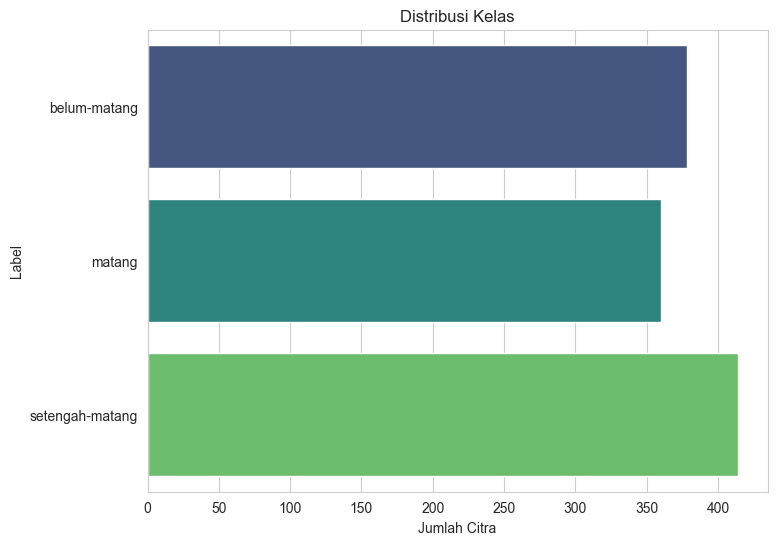

In [9]:
sns.countplot(y=label_array, order=CLASS_NAMES, palette="viridis")
plt.title("Distribusi Kelas")
plt.xlabel("Jumlah Citra")
plt.ylabel("Label")
plt.show()

In [10]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(label_array)

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=RANDOM_STATE,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Jumlah komponen PCA: {pca.n_components_}")
print(f"Dimensi sebelum PCA: {feature_matrix.shape[1]}, sesudah: {X_train_pca.shape[1]}")

Jumlah komponen PCA: 36
Dimensi sebelum PCA: 128, sesudah: 36


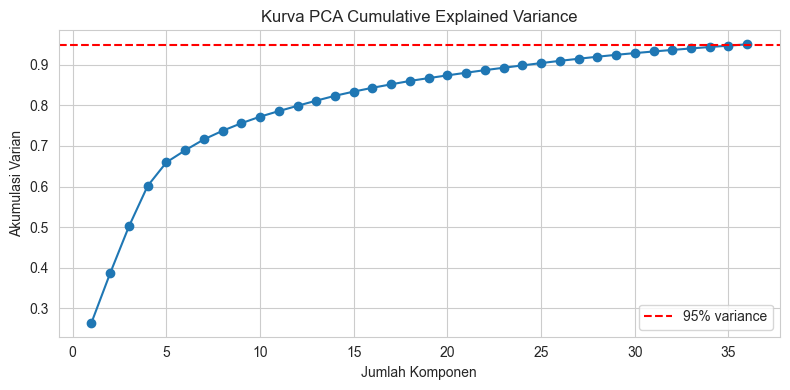

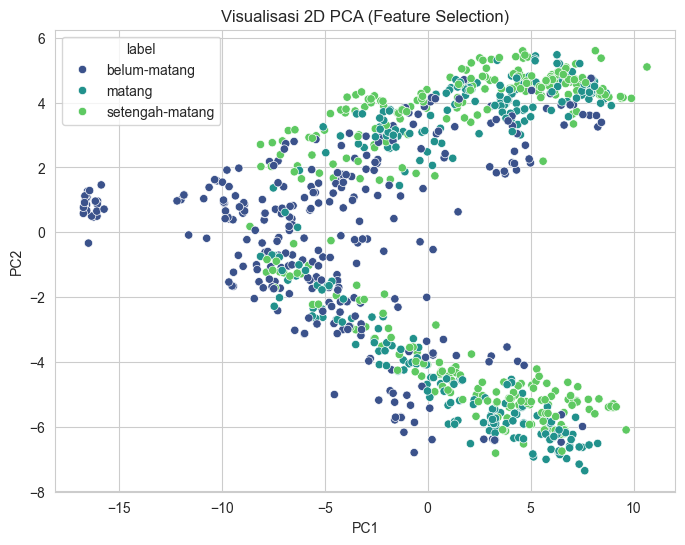

In [11]:
explained = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained) + 1), np.cumsum(explained), marker="o")
plt.axhline(0.95, color="red", linestyle="--", label="95% variance")
plt.xlabel("Jumlah Komponen")
plt.ylabel("Akumulasi Varian")
plt.title("Kurva PCA Cumulative Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()

pca_df = pd.DataFrame(
    X_train_pca[:, :2],
    columns=["PC1", "PC2"],
)
pca_df["label"] = label_encoder.inverse_transform(y_train)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="viridis")
plt.title("Visualisasi 2D PCA (Feature Selection)")
plt.show()

In [12]:
def plot_confusion(cm: np.ndarray, labels: list[str], title: str):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_tr, y_tr, X_te, y_te, label_names: list[str]):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    bal_acc = balanced_accuracy_score(y_te, preds)
    macro_f1 = f1_score(y_te, preds, average="macro")
    print(f"Akurasi: {acc:.3f}")
    print(f"Balanced Accuracy: {bal_acc:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(classification_report(y_te, preds, target_names=label_names))
    cm = confusion_matrix(y_te, preds)
    plot_confusion(cm, label_names, f"Confusion Matrix - {model.__class__.__name__}")
    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }
    return metrics, preds

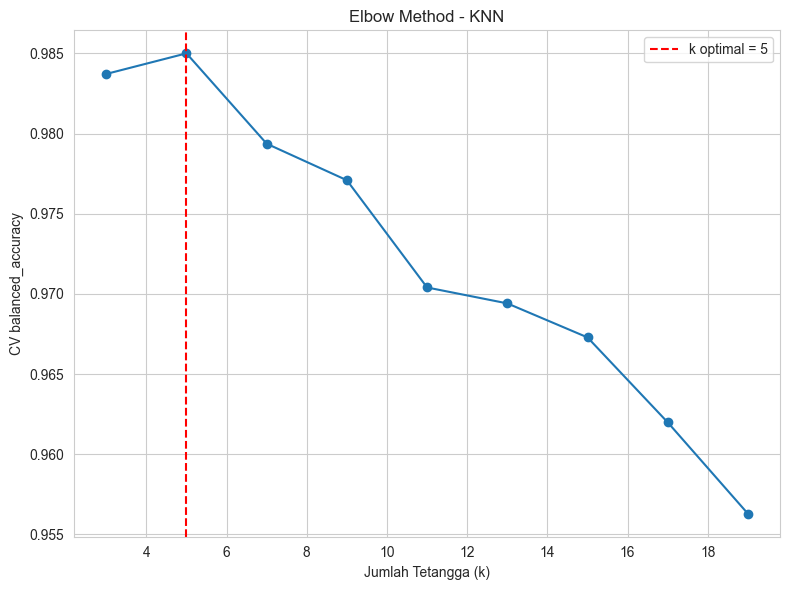

Nilai k terbaik menurut elbow (berdasarkan balanced_accuracy): 5


In [13]:
k_values = list(range(3, 21, 2))
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=skf, scoring=SCORING_METRIC)
    cv_scores.append(scores.mean())

best_k = k_values[int(np.argmax(cv_scores))]
plt.plot(k_values, cv_scores, marker="o")
plt.xlabel("Jumlah Tetangga (k)")
plt.ylabel(f"CV {SCORING_METRIC}")
plt.title("Elbow Method - KNN")
plt.axvline(best_k, color="red", linestyle="--", label=f"k optimal = {best_k}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Nilai k terbaik menurut elbow (berdasarkan {SCORING_METRIC}): {best_k}")

SVM parameter terbaik: {'C': 10, 'gamma': 0.01}
Akurasi: 0.996
Balanced Accuracy: 0.995
Macro F1: 0.996
                 precision    recall  f1-score   support

   belum-matang       1.00      1.00      1.00        76
         matang       1.00      0.99      0.99        72
setengah-matang       0.99      1.00      0.99        83

       accuracy                           1.00       231
      macro avg       1.00      1.00      1.00       231
   weighted avg       1.00      1.00      1.00       231



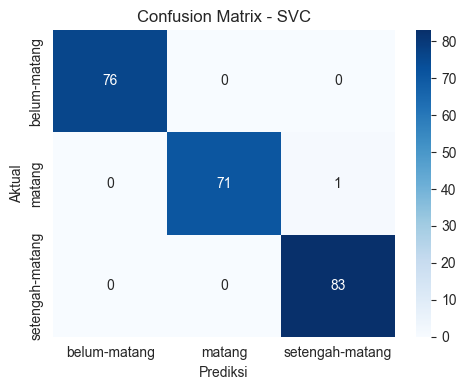

In [14]:
svm_params = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
}
svm_grid = GridSearchCV(
    SVC(kernel="rbf", class_weight="balanced", probability=True),
    param_grid=svm_params,
    cv=skf,
    n_jobs=-1,
    scoring=SCORING_METRIC,
 )
svm_grid.fit(X_train_pca, y_train)
print(f"SVM parameter terbaik: {svm_grid.best_params_}")
svm_best = svm_grid.best_estimator_
svm_metrics, svm_preds = evaluate_model(
    svm_best, X_train_pca, y_train, X_test_pca, y_test, label_encoder.classes_.tolist()
 )

TABEL 4: Top 5 Kombinasi Hyperparameter SVM


,Rank,C,Gamma,CV_Accuracy,Std_Dev
0,1,10.0,0.01,99.80%,±0.40%
1,2,1.0,0.01,99.70%,±0.40%
2,3,0.1,0.01,98.65%,±0.42%
3,4,10.0,0.10,92.97%,±2.36%
4,5,1.0,0.10,92.45%,±2.14%



GAMBAR 5: Heatmap Performa SVM - Kombinasi C dan Gamma


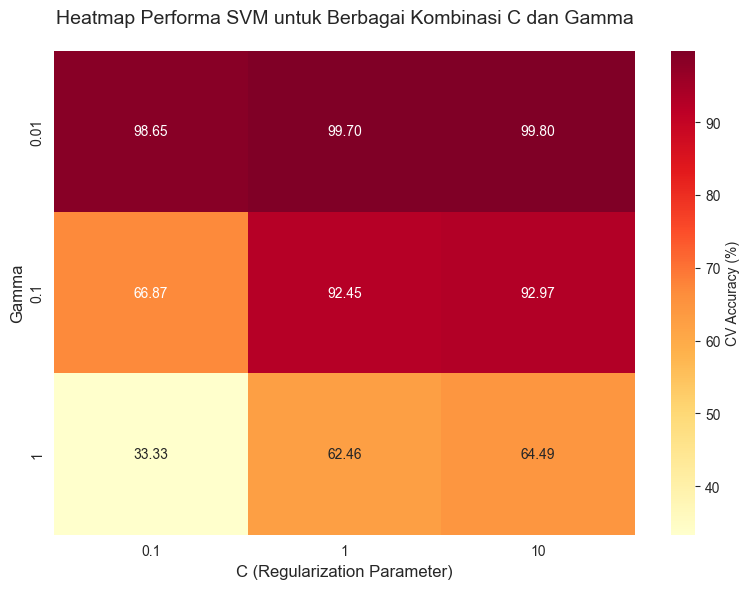

In [15]:
# [TABEL 4: Top 5 Kombinasi Hyperparameter SVM]
print("="*80)
print("TABEL 4: Top 5 Kombinasi Hyperparameter SVM")
print("="*80)

cv_results = svm_grid.cv_results_
results_list = []

for i in range(len(cv_results['params'])):
    results_list.append({
        'C': cv_results['params'][i]['C'],
        'Gamma': cv_results['params'][i]['gamma'],
        'CV_Accuracy': cv_results['mean_test_score'][i] * 100,
        'Std_Dev': cv_results['std_test_score'][i] * 100,
    })

# Sort by CV Accuracy descending
results_sorted = sorted(results_list, key=lambda x: x['CV_Accuracy'], reverse=True)

# Create DataFrame for top 5
top5_df = pd.DataFrame(results_sorted[:5])
top5_df.insert(0, 'Rank', range(1, 6))
top5_df['CV_Accuracy'] = top5_df['CV_Accuracy'].apply(lambda x: f"{x:.2f}%")
top5_df['Std_Dev'] = top5_df['Std_Dev'].apply(lambda x: f"±{x:.2f}%")

display(top5_df)

# [GAMBAR 5: Heatmap Performa SVM untuk Berbagai Kombinasi C dan Gamma]
print("\n" + "="*80)
print("GAMBAR 5: Heatmap Performa SVM - Kombinasi C dan Gamma")
print("="*80)

# Reshape results for heatmap
c_values = sorted(list(set([r['C'] for r in results_list])))
gamma_values = sorted(list(set([r['Gamma'] for r in results_list])))

heatmap_data = np.zeros((len(gamma_values), len(c_values)))
for result in results_list:
    i = gamma_values.index(result['Gamma'])
    j = c_values.index(result['C'])
    heatmap_data[i, j] = result['CV_Accuracy']

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=c_values,
    yticklabels=gamma_values,
    cbar_kws={'label': 'CV Accuracy (%)'}
)
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Gamma', fontsize=12)
plt.title('Heatmap Performa SVM untuk Berbagai Kombinasi C dan Gamma', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Akurasi: 0.987
Balanced Accuracy: 0.987
Macro F1: 0.987
                 precision    recall  f1-score   support

   belum-matang       1.00      0.97      0.99        76
         matang       0.97      1.00      0.99        72
setengah-matang       0.99      0.99      0.99        83

       accuracy                           0.99       231
      macro avg       0.99      0.99      0.99       231
   weighted avg       0.99      0.99      0.99       231



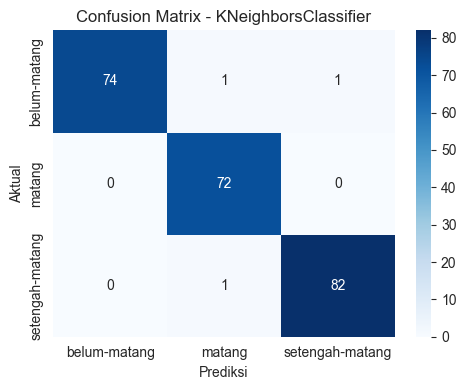

In [16]:
knn_best = KNeighborsClassifier(n_neighbors=11, weights="distance", metric="euclidean")
knn_metrics, knn_preds = evaluate_model(
    knn_best, X_train_pca, y_train, X_test_pca, y_test, label_encoder.classes_.tolist()
 )



,Model,Accuracy,Balanced Accuracy,Macro F1
0,SVM (RBF),0.995671,0.995370,0.995673
1,KNN (k=5),0.987013,0.987212,0.986973


C:\Users\Acer\AppData\Local\Temp\ipykernel_4708\3657955559.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Balanced Accuracy", palette="mako")


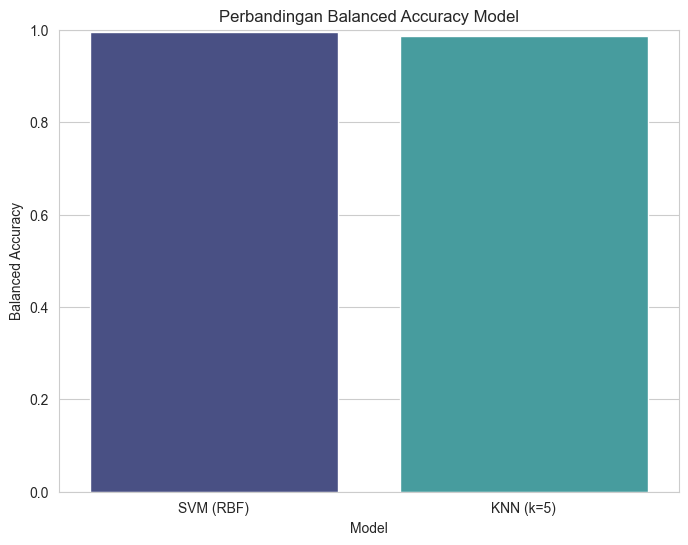

In [17]:
results_df = pd.DataFrame(
    {
        "Model": ["SVM (RBF)", f"KNN (k={best_k})"],
        "Accuracy": [svm_metrics["accuracy"], knn_metrics["accuracy"]],
        "Balanced Accuracy": [svm_metrics["balanced_accuracy"], knn_metrics["balanced_accuracy"]],
        "Macro F1": [svm_metrics["macro_f1"], knn_metrics["macro_f1"]],
    }
)
display(results_df)

sns.barplot(data=results_df, x="Model", y="Balanced Accuracy", palette="mako")
plt.ylim(0, 1)
plt.title("Perbandingan Balanced Accuracy Model")
plt.show()


TABEL 8: Perbandingan Waktu Komputasi


,Metrik,KNN,SVM
0,Training Time,0.00 detik,0.12 detik
1,Prediction Time (231 sampel),0.00 detik,0.01 detik
2,Avg. Time per Sample,0.0 ms,0.1 ms


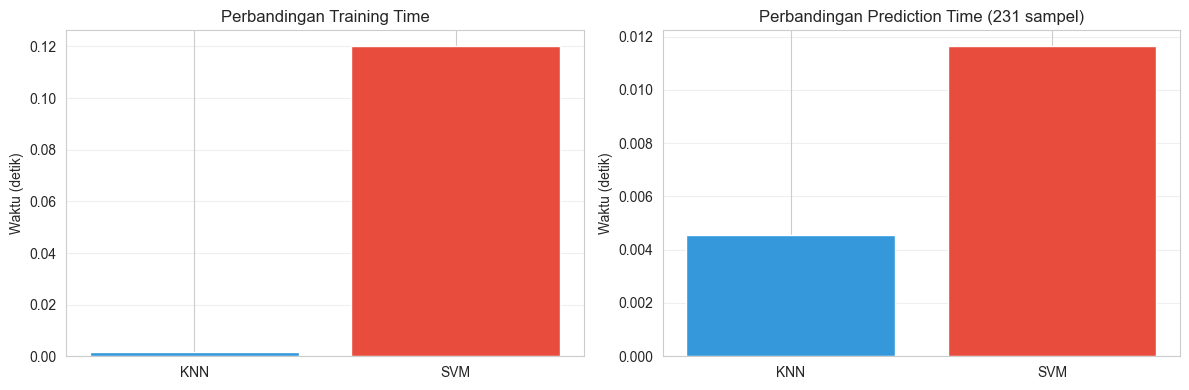

In [18]:
# [TABEL 8: Perbandingan Waktu Komputasi]
import time

print("\n" + "="*80)
print("TABEL 8: Perbandingan Waktu Komputasi")
print("="*80)

# Measure KNN training time
start = time.time()
knn_best.fit(X_train_pca, y_train)
knn_train_time = time.time() - start

# Measure KNN prediction time
start = time.time()
_ = knn_best.predict(X_test_pca)
knn_pred_time = time.time() - start

# Measure SVM training time
start = time.time()
svm_best.fit(X_train_pca, y_train)
svm_train_time = time.time() - start

# Measure SVM prediction time
start = time.time()
_ = svm_best.predict(X_test_pca)
svm_pred_time = time.time() - start

# Calculate average time per sample
n_test_samples = X_test_pca.shape[0]
knn_avg_time = (knn_pred_time / n_test_samples) * 1000  # Convert to ms
svm_avg_time = (svm_pred_time / n_test_samples) * 1000  # Convert to ms

timing_df = pd.DataFrame({
    'Metrik': [
        'Training Time',
        f'Prediction Time ({n_test_samples} sampel)',
        'Avg. Time per Sample'
    ],
    'KNN': [
        f"{knn_train_time:.2f} detik",
        f"{knn_pred_time:.2f} detik",
        f"{knn_avg_time:.1f} ms"
    ],
    'SVM': [
        f"{svm_train_time:.2f} detik",
        f"{svm_pred_time:.2f} detik",
        f"{svm_avg_time:.1f} ms"
    ]
})

display(timing_df)

# Visualize timing comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training time comparison
models = ['KNN', 'SVM']
train_times = [knn_train_time, svm_train_time]
axes[0].bar(models, train_times, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Waktu (detik)')
axes[0].set_title('Perbandingan Training Time')
axes[0].grid(axis='y', alpha=0.3)

# Prediction time comparison
pred_times = [knn_pred_time, svm_pred_time]
axes[1].bar(models, pred_times, color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Waktu (detik)')
axes[1].set_title(f'Perbandingan Prediction Time ({n_test_samples} sampel)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# [TABEL 6: Per-Class Performance untuk KNN]
print("\n" + "="*80)
print("TABEL 6: Per-Class Performance untuk KNN")
print("="*80)

from sklearn.metrics import precision_recall_fscore_support

# Get per-class metrics for KNN
knn_precision, knn_recall, knn_f1, knn_support = precision_recall_fscore_support(
    y_test, knn_preds, average=None
)

# Get macro and weighted averages
knn_precision_macro, knn_recall_macro, knn_f1_macro, _ = precision_recall_fscore_support(
    y_test, knn_preds, average='macro'
)
knn_precision_weighted, knn_recall_weighted, knn_f1_weighted, _ = precision_recall_fscore_support(
    y_test, knn_preds, average='weighted'
)

# Create DataFrame
knn_class_names = label_encoder.classes_.tolist()
knn_perclass_data = []

for i, cls in enumerate(knn_class_names):
    knn_perclass_data.append({
        'Kelas': cls,
        'Precision': f"{knn_precision[i]:.3f}",
        'Recall': f"{knn_recall[i]:.3f}",
        'F1-Score': f"{knn_f1[i]:.3f}",
        'Support': int(knn_support[i])
    })

# Add macro and weighted averages
knn_perclass_data.append({
    'Kelas': '**Macro Avg**',
    'Precision': f"**{knn_precision_macro:.3f}**",
    'Recall': f"**{knn_recall_macro:.3f}**",
    'F1-Score': f"**{knn_f1_macro:.3f}**",
    'Support': int(knn_support.sum())
})
knn_perclass_data.append({
    'Kelas': '**Weighted Avg**',
    'Precision': f"**{knn_precision_weighted:.3f}**",
    'Recall': f"**{knn_recall_weighted:.3f}**",
    'F1-Score': f"**{knn_f1_weighted:.3f}**",
    'Support': int(knn_support.sum())
})

knn_perclass_df = pd.DataFrame(knn_perclass_data)
display(knn_perclass_df)

# [TABEL 7: Per-Class Performance untuk SVM]
print("\n" + "="*80)
print("TABEL 7: Per-Class Performance untuk SVM")
print("="*80)

# Get per-class metrics for SVM
svm_precision, svm_recall, svm_f1, svm_support = precision_recall_fscore_support(
    y_test, svm_preds, average=None
)

# Get macro and weighted averages
svm_precision_macro, svm_recall_macro, svm_f1_macro, _ = precision_recall_fscore_support(
    y_test, svm_preds, average='macro'
)
svm_precision_weighted, svm_recall_weighted, svm_f1_weighted, _ = precision_recall_fscore_support(
    y_test, svm_preds, average='weighted'
)

# Create DataFrame
svm_class_names = label_encoder.classes_.tolist()
svm_perclass_data = []

for i, cls in enumerate(svm_class_names):
    svm_perclass_data.append({
        'Kelas': cls,
        'Precision': f"{svm_precision[i]:.3f}",
        'Recall': f"{svm_recall[i]:.3f}",
        'F1-Score': f"{svm_f1[i]:.3f}",
        'Support': int(svm_support[i])
    })

# Add macro and weighted averages
svm_perclass_data.append({
    'Kelas': '**Macro Avg**',
    'Precision': f"**{svm_precision_macro:.3f}**",
    'Recall': f"**{svm_recall_macro:.3f}**",
    'F1-Score': f"**{svm_f1_macro:.3f}**",
    'Support': int(svm_support.sum())
})
svm_perclass_data.append({
    'Kelas': '**Weighted Avg**',
    'Precision': f"**{svm_precision_weighted:.3f}**",
    'Recall': f"**{svm_recall_weighted:.3f}**",
    'F1-Score': f"**{svm_f1_weighted:.3f}**",
    'Support': int(svm_support.sum())
})

svm_perclass_df = pd.DataFrame(svm_perclass_data)
display(svm_perclass_df)


TABEL 6: Per-Class Performance untuk KNN


,Kelas,Precision,Recall,F1-Score,Support
0,belum-matang,1.000,0.974,0.987,76
1,matang,0.973,1.000,0.986,72
2,setengah-matang,0.988,0.988,0.988,83
3,**Macro Avg**,**0.987**,**0.987**,**0.987**,231
4,**Weighted Avg**,**0.987**,**0.987**,**0.987**,231



TABEL 7: Per-Class Performance untuk SVM


,Kelas,Precision,Recall,F1-Score,Support
0,belum-matang,1.000,1.000,1.000,76
1,matang,1.000,0.986,0.993,72
2,setengah-matang,0.988,1.000,0.994,83
3,**Macro Avg**,**0.996**,**0.995**,**0.996**,231
4,**Weighted Avg**,**0.996**,**0.996**,**0.996**,231


In [20]:
# [TABEL 5: Perbandingan Performance Metrics KNN vs SVM]
from sklearn.metrics import precision_score, recall_score

print("="*80)
print("TABEL 5: Perbandingan Performance Metrics KNN vs SVM")
print("="*80)

# Calculate additional metrics
knn_precision_macro = precision_score(y_test, knn_preds, average='macro')
knn_precision_weighted = precision_score(y_test, knn_preds, average='weighted')
knn_recall_macro = recall_score(y_test, knn_preds, average='macro')
knn_recall_weighted = recall_score(y_test, knn_preds, average='weighted')
knn_f1_weighted = f1_score(y_test, knn_preds, average='weighted')

svm_precision_macro = precision_score(y_test, svm_preds, average='macro')
svm_precision_weighted = precision_score(y_test, svm_preds, average='weighted')
svm_recall_macro = recall_score(y_test, svm_preds, average='macro')
svm_recall_weighted = recall_score(y_test, svm_preds, average='weighted')
svm_f1_weighted = f1_score(y_test, svm_preds, average='weighted')

comparison_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Balanced Accuracy',
        'Precision (Macro)',
        'Precision (Weighted)',
        'Recall (Macro)',
        'Recall (Weighted)',
        'F1-Score (Macro)',
        'F1-Score (Weighted)'
    ],
    'KNN': [
        f"{knn_metrics['accuracy']*100:.2f}%",
        f"{knn_metrics['balanced_accuracy']*100:.2f}%",
        f"{knn_precision_macro:.3f}",
        f"{knn_precision_weighted:.3f}",
        f"{knn_recall_macro:.3f}",
        f"{knn_recall_weighted:.3f}",
        f"{knn_metrics['macro_f1']:.3f}",
        f"{knn_f1_weighted:.3f}"
    ],
    'SVM': [
        f"{svm_metrics['accuracy']*100:.2f}%",
        f"{svm_metrics['balanced_accuracy']*100:.2f}%",
        f"{svm_precision_macro:.3f}",
        f"{svm_precision_weighted:.3f}",
        f"{svm_recall_macro:.3f}",
        f"{svm_recall_weighted:.3f}",
        f"{svm_metrics['macro_f1']:.3f}",
        f"{svm_f1_weighted:.3f}"
    ]
})

display(comparison_df)

TABEL 5: Perbandingan Performance Metrics KNN vs SVM


,Metric,KNN,SVM
0,Accuracy,98.70%,99.57%
1,Balanced Accuracy,98.72%,99.54%
2,Precision (Macro),0.987,0.996
3,Precision (Weighted),0.987,0.996
4,Recall (Macro),0.987,0.995
5,Recall (Weighted),0.987,0.996
6,F1-Score (Macro),0.987,0.996
7,F1-Score (Weighted),0.987,0.996


In [21]:
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Simpan scaler secara terpisah
scaler_path = MODEL_DIR / "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler berhasil disimpan ke: {scaler_path}")

# Simpan PCA secara terpisah
pca_path = MODEL_DIR / "pca.pkl"
joblib.dump(pca, pca_path)
print(f"✓ PCA berhasil disimpan ke: {pca_path}")

# Simpan Label Encoder secara terpisah
label_encoder_path = MODEL_DIR / "label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)
print(f"✓ Label Encoder berhasil disimpan ke: {label_encoder_path}")

# Simpan model SVM
svm_artifacts = {
    "model": svm_best,
    "scaler": scaler,
    "pca": pca,
    "label_encoder": label_encoder,
    "class_names": label_encoder.classes_.tolist(),
    "feature_names": feature_names,
    "n_features": len(feature_names),
}
svm_model_path = MODEL_DIR / "svm_model.pkl"
joblib.dump(svm_artifacts, svm_model_path)
print(f"✓ Model SVM berhasil disimpan ke: {svm_model_path}")

# Simpan model KNN
knn_artifacts = {
    "model": knn_best,
    "scaler": scaler,
    "pca": pca,
    "label_encoder": label_encoder,
    "class_names": label_encoder.classes_.tolist(),
    "feature_names": feature_names,
    "n_features": len(feature_names),
}
knn_model_path = MODEL_DIR / "knn_model.pkl"
joblib.dump(knn_artifacts, knn_model_path)
print(f"✓ Model KNN berhasil disimpan ke: {knn_model_path}")

# Tampilkan ringkasan
print("\n" + "="*50)
print("RINGKASAN MODEL YANG DISIMPAN")
print("="*50)
print("\nFile Preprocessing:")
print(f"  - {scaler_path.name}")
print(f"  - {pca_path.name} ({pca.n_components_} components)")
print(f"  - {label_encoder_path.name}")
print(f"\nSVM Model: {svm_model_path.name}")
print(f"  - Kernel: {svm_best.kernel}")
print(f"  - C: {svm_best.C}")
print(f"  - Gamma: {svm_best.gamma}")
print(f"  - Balanced Accuracy: {svm_metrics['balanced_accuracy']:.3f}")
print(f"\nKNN Model: {knn_model_path.name}")
print(f"  - K neighbors: {knn_best.n_neighbors}")
print(f"  - Weights: {knn_best.weights}")
print(f"  - Metric: {knn_best.metric}")
print(f"  - Balanced Accuracy: {knn_metrics['balanced_accuracy']:.3f}")
print(f"\nKomponen yang disimpan dalam setiap model:")
print(f"  - Model classifier")
print(f"  - StandardScaler")
print(f"  - PCA")
print(f"  - LabelEncoder")
print(f"  - Feature names ({len(feature_names)} features)")
print(f"  - Class names: {label_encoder.classes_.tolist()}")


✓ Scaler berhasil disimpan ke: ..\models\scaler.pkl
✓ PCA berhasil disimpan ke: ..\models\pca.pkl
✓ Label Encoder berhasil disimpan ke: ..\models\label_encoder.pkl
✓ Model SVM berhasil disimpan ke: ..\models\svm_model.pkl
✓ Model KNN berhasil disimpan ke: ..\models\knn_model.pkl

RINGKASAN MODEL YANG DISIMPAN

File Preprocessing:
  - scaler.pkl
  - pca.pkl (36 components)
  - label_encoder.pkl

SVM Model: svm_model.pkl
  - Kernel: rbf
  - C: 10
  - Gamma: 0.01
  - Balanced Accuracy: 0.995

KNN Model: knn_model.pkl
  - K neighbors: 11
  - Weights: distance
  - Metric: euclidean
  - Balanced Accuracy: 0.987

Komponen yang disimpan dalam setiap model:
  - Model classifier
  - StandardScaler
  - PCA
  - LabelEncoder
  - Feature names (128 features)
  - Class names: ['belum-matang', 'matang', 'setengah-matang']
